<img src="Instacart_logo_small.png" alt="Instacart" style="width: 100px;"/>

# Recommend products to Instacart Customers

## Introduction

> <font color=orange>There's nothing better than online shopping in your PJ's with a glass of wine with the kids asleep!</font> 

<br>Online Shopping is a boon to many people. No more makeup, no more worries about the bad hair day and no more looking for a parking spot -  The entire Retail World is just a click away. Receiving all your groceries at your doorstep on the same day is Fun. **Instacart** is the name who offers this service.
<br><br> So, how does that actually work?
<br><br>Customers place orders online through a Mobile app or using the website to be fulfilled from one of their grocery retail partners. A personal shopper engaged by Instacart picks the items in the store and delivers them in as little as an hour or at the time the customer selects. Sounds really Simple right? But in the back end, lots of algorithms and calculation makes the process happen. 

## Data

For this project, I am using the Dataset from “The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on 07/10/2019.
<br><br>This anonymized dataset contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, the dataset provides between 4 and 100 of their orders, with the sequence of products purchased in each order. It also provides the week and hour of day the order was placed, and a relative measure of time between the orders.

#### Load Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### Load Order Details

In [2]:
df_orders = pd.read_csv('instacart_2017_05_01/orders.csv')
df_orders.shape

(3421083, 7)

In [3]:
df_orders.head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0


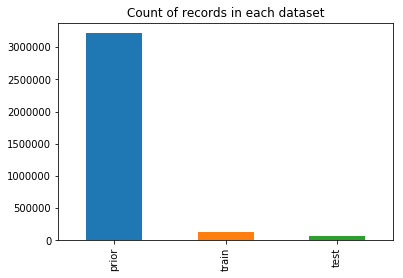

In [4]:
df_orders.eval_set.value_counts().plot("bar", title = "Count of records in each dataset")

#### Load Prior Order Details

In [5]:
df_order_prior = pd.read_csv('instacart_2017_05_01/order_products_prior.csv')
df_order_prior.shape

(32434489, 4)

In [6]:
df_order_prior.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0


#### Load Train Order Details

In [7]:
df_order_train = pd.read_csv('instacart_2017_05_01/order_products_train.csv')
df_order_train.shape

(1384617, 4)

In [8]:
df_order_train.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0


#### Load Products

In [9]:
df_products = pd.read_csv('instacart_2017_05_01/products.csv')
df_products.shape

(49688, 4)

In [10]:
df_products.head(3)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7


#### Load Departments

In [11]:
df_departments = pd.read_csv('instacart_2017_05_01/departments.csv')
df_departments.shape

(21, 2)

In [12]:
df_departments.head(3)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery


#### Load Aisles

In [13]:
df_aisles = pd.read_csv('instacart_2017_05_01/aisles.csv')
df_aisles.shape

(134, 2)

In [14]:
df_aisles.head(3)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars


So, Now let's check out some important **Numbers**!

In [15]:
print("Total Aisles:          ", df_products.aisle_id.nunique())
print("Total Departments:     ", df_products.department_id.nunique())
print("Unique Products:       ", df_products.product_id.nunique())
print("Total Users/Customers: ", df_orders.user_id.nunique())
print("Total Orders:          ", df_orders.order_id.nunique())

Total Aisles:           134
Total Departments:      21
Unique Products:        49688
Total Users/Customers:  206209
Total Orders:           3421083


## Data Wrangling

### 1. Combine aisles, departments and products

In [16]:
df_items = pd.merge(left=pd.merge(left=df_products, right=df_departments, how='left'), right=df_aisles, how='left')
df_items.head(3)

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea


### 2. Combine Prior Orders and Products

In [17]:
df_prior = pd.merge(df_order_prior,df_items, on ='product_id')
df_prior.shape

(32434489, 9)

### 3. Combine Train Orders and Products¶

In [18]:
df_train = pd.merge(df_order_train,df_items, on ='product_id')
df_train.shape

(1384617, 9)

### 4. Combine Prior orders and Order Details

In [19]:
df_prior_orders = pd.merge(df_prior,df_orders, on ='order_id')
df_prior_orders.shape

(32434489, 15)

### 5. Combine Train Orders and Order Details

In [20]:
df_train_orders = pd.merge(df_train,df_orders, on ='order_id')
df_train_orders.shape

(1384617, 15)

### 6. Merge The Train and Prior Dataset

In [21]:
print("Unique Customer Count in Train Dataset: ", df_train_orders['user_id'].nunique())
print("Unique Customer Count in Prior Dataset: ", df_prior_orders['user_id'].nunique())

Unique Customer Count in Train Dataset:  131209
Unique Customer Count in Prior Dataset:  206209


Get the Users whose information is there in both the Training and Prior Dataset.

In [21]:
train_users = df_train_orders['user_id'].unique()
prior_users = df_prior_orders['user_id'].unique()
prior_users[np.in1d(prior_users, train_users)]

array([202279, 153404,  58707, ..., 120516, 166751,  22711])

Nown let's merge the training dataset and the prior order dataset only for those users whose information is there in both the sets. 

In [22]:
df_final = pd.concat([df_prior_orders[df_prior_orders.user_id.isin(train_users)],df_train_orders] ) 
df_final.shape

(22026608, 15)

### 7. Convert NAN values to Zero

In [23]:
df_final['days_since_prior_order'] = df_final['days_since_prior_order'].fillna(0).astype(np.int64)

### 8. Change Column DataTypes

In [24]:
df_final.eval_set = df_final.eval_set.astype('category')
df_final.department = df_final.department.astype('category')
df_final.aisle = df_final.aisle.astype('category')
df_final.reordered = df_final.reordered.astype('bool')

### 9. Sort the Data

In [25]:
df_final = df_final.sort_values(['user_id', 'order_number','add_to_cart_order'])

In [26]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22026608 entries, 22667633 to 904144
Data columns (total 15 columns):
order_id                  int64
product_id                int64
add_to_cart_order         int64
reordered                 bool
product_name              object
aisle_id                  int64
department_id             int64
department                category
aisle                     category
user_id                   int64
eval_set                  category
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    int64
dtypes: bool(1), category(3), int64(10), object(1)
memory usage: 2.1+ GB


## Feature Extraction

### Size of the Order

In [27]:
df_final['order_size'] = df_final.groupby('order_id')['order_id'].transform('count')

### Total Orders per Customer

In [28]:
df_final['total_order_count'] = df_final.groupby(['user_id'])['order_id'].transform('nunique')

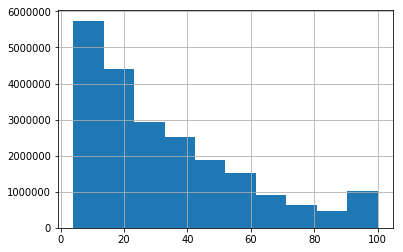

In [29]:
df_final['total_order_count'].hist()

In [30]:
print("Min. Order Count: ", df_final['total_order_count'].min())
print("Max. Order Count: ", df_final['total_order_count'].max())
print("Avg. Order Count: ", df_final['total_order_count'].mean())

Min. Order Count:  4
Max. Order Count:  100
Avg. Order Count:  32.966760156625114


### Potential Customer

In [31]:
df_final['potential_customer']=  np.where(df_final['total_order_count'] > df_final['total_order_count'].mean(), True, False) 

### For how long the Customer is doing transactions?

In [32]:
df_order_span = pd.DataFrame(df_final.groupby('user_id')['days_since_prior_order'].sum().reset_index())
df_order_span.columns = ['user_id', 'days_order_span']
df_final = pd.merge(df_final,df_order_span, on ='user_id')

### Is the Product Organic?

In [33]:
df_final.product_name = df_final.product_name.str.lower()
df_final["is_organic"] = df_final.product_name.str.contains('organic')
df_final["is_organic"].value_counts()

False    15082541
True      6944067
Name: is_organic, dtype: int64

### How Many times a customer bought a product?

In [34]:
item = df_final.groupby(['product_id', 'user_id']).size().reset_index()
item.columns = ['product_id','user_id','user_item_count']

In [35]:
df_final = pd.merge(df_final,item, on =['product_id','user_id'])

In [36]:
df_final.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle,user_id,...,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_size,total_order_count,potential_customer,days_order_span,is_organic,user_item_count
0,2539329,196,1,False,soda,77,7,beverages,soft drinks,1,...,1,2,8,0,5,11,False,1248,False,11
1,2398795,196,1,True,soda,77,7,beverages,soft drinks,1,...,2,3,7,15,6,11,False,1248,False,11
2,473747,196,1,True,soda,77,7,beverages,soft drinks,1,...,3,3,12,21,5,11,False,1248,False,11
3,2254736,196,1,True,soda,77,7,beverages,soft drinks,1,...,4,4,7,29,5,11,False,1248,False,11
4,431534,196,1,True,soda,77,7,beverages,soft drinks,1,...,5,4,15,28,8,11,False,1248,False,11


### Save the Dataframe for EDA in the next section

In [37]:
df_final.to_csv("data_final.csv")